# Preamble

For my final project I am furthering the analysis of an original research project that I'm in the midst of right now. It is well known that geomagnetic storms can induce electric current in transformers, substations, and transmission lines. (see: https://www.swpc.noaa.gov/impacts/electric-power-transmission) The question I am investigating is whether or not geogmagnetic activity leads to a spike in the energy price. The project will be discussed further in the hypothesis section.


The following libraries were required for the analysis performed:
 - numpy
 - pandas
 - scipy.stats
 - matplotlib.pyplot
 - sklearn
 - seaborn


In [237]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Data
 
There are two sources for my data: the Kp Index, a value measuring geomagnetic disturbances, published by the Space Weather Prediction Center at NOAA, made available at: https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_since_1932.txt, info about https://www.swpc.noaa.gov/products/planetary-k-index. The Kp values are published every three hours in UCT and are floats ranging from 0 to 9. Any value above 5 or 6 is considered to be storm level. I converted the timestamp into ET and extended the 3hr intervals into 5min intervals.

The other source of data is wholesale energy price data. I chose the NYISO (NY Independent System Operator) market because they have data available at 5-min intervals and their data is easy to scrape from the website. The data accessed is NYISO LBMP Zonal data in 5min intervals, downloaded from: http://mis.nyiso.com/public/P-24Alist.htm.

The data for both sources is from '2000-01-01 00:05:00' to '2022-01-02 00:05:00' (ET). There are 16 regional hubs in the NYISO market, so the hubs prices were averaged for each timestamp to get the overall grid market price for ease of analysis. NYISO is a small market geographically and all the hubs have about the same latitude so this should not affect the results. 

Finally, after wrangling with making sure each dataset's timestamps aligned, I merged them based on their ET column.

I did the scraping and initial cleaning awhile ago, and the process was quite time-consuming, onerous, and entailed downloading and unzipping multiple zip files. And so I just uploaded the merged dataset ('NYISO merge.csv') which contains the results of that merging.

The dataset has 2509248 rows x 16 columns. The columns names are 

'Unnamed: 0'

'Kp'

'Time Stamp'

'LBMP($/MWHr)'

We are interested in the relationship between Kp (maybe with a time lag) and LBMP ($/MWHr) spikes.

In [238]:
df = pd.read_csv('NYISO merge.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [239]:
#define price spikes by normalization of prices in next 3 hours
df['3hr avg'] = df['LBMP ($/MWHr)'].rolling(36).mean()
df['3hr std'] = df['LBMP ($/MWHr)'].rolling(36).std()
df['3hr z-scores'] = (df['LBMP ($/MWHr)'] - df['3hr avg'])/df['3hr std']
df['3hr p-values'] = scipy.stats.norm.sf(abs(df['3hr z-scores']))*2

#binary variable that equals 1 if price at 5 min interval is a spike
df['3hr spike'] = np.where(df['3hr p-values'] <= 0.001,1,0)

#binary variable that returns True if spike occurs in next 3 hours
df['3hr spike: any'] = df['3hr spike'].shift(-35).eq(1).rolling(36).apply(lambda x: x.any())

#binary variable that returns True if spike occurs in next 24 hours
df['24hr spike: any'] = df['3hr spike'].shift(-287).eq(1).rolling(288).apply(lambda x: x.any())

#count number of spikes that exist in next 3 hours
df['3hr spike: sum'] = df['3hr spike'].shift(-35).eq(1).rolling(36).sum()

#count number of spikes that exist in next 24 hours
df['24hr spike: sum'] = df['3hr spike'].shift(-287).eq(1).rolling(288).sum()

In [240]:
df = df.dropna()
df = df.reset_index()

In [241]:
df

,index,Kp,ET,Time Stamp,LBMP ($/MWHr),3hr avg,3hr std,3hr z-scores,3hr p-values,3hr spike,3hr spike: any,24hr spike: any,3hr spike: sum,24hr spike: sum
0,287,3.333,2000-01-02 15:05:00,01/02/2000 15:00:34,15.382667,16.264130,0.553539,-1.592415,0.111292,0,1.0,1.0,8.0,14.0
1,288,3.333,2000-01-02 15:05:00,01/02/2000 15:01:34,15.568000,16.219574,0.542825,-1.200339,0.230008,0,1.0,1.0,8.0,14.0
2,289,3.333,2000-01-02 15:10:00,01/02/2000 15:06:34,15.252667,16.160741,0.529106,-1.716242,0.086118,0,1.0,1.0,8.0,14.0
3,290,3.333,2000-01-02 15:15:00,01/02/2000 15:11:34,15.049333,16.101241,0.530337,-1.983469,0.047315,0,1.0,1.0,8.0,14.0
4,291,3.333,2000-01-02 15:20:00,01/02/2000 15:16:34,15.228000,16.055519,0.532760,-1.553268,0.120359,0,1.0,1.0,8.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508951,2509243,1.667,2022-01-01 23:45:00,01/01/2022 23:40:00,23.658000,27.375833,2.361228,-1.574534,0.115364,0,0.0,0.0,0.0,0.0
2508952,2509244,1.667,2022-01-01 23:50:00,01/01/2022 23:45:00,23.661333,27.282296,2.440731,-1.483557,0.137927,0,0.0,0.0,0.0,0.0
2508953,2509245,1.667,2022-01-01 23:55:00,01/01/2022 23:50:00,27.986000,27.268667,2.435235,0.294564,0.768327,0,0.0,0.0,0.0,0.0
2508954,2509246,1.667,2022-01-02 00:00:00,01/01/2022 23:55:00,28.029333,27.256463,2.430145,0.318035,0.750459,0,0.0,0.0,0.0,0.0


# Hypothesis

The idea is that there is a relationship between geomagnetic storms and price spikes in wholesale energy markets. There are many ways to try to validate this relationship. We are not sure at what threshhold, duration, or intensity of geomagnetic activity is required to predict wholesale energy prices. In previous analyses of my research project, I selected three sample storm events with intense geomagnetic activity, and observe multiple significant spikes during those 1-2 day intervals. I also previously attempted to examine the fraction of 3hr-intervals with Kp above a certain value that observe a spike in that interval. The fractions were not substantially different than the overall fraction of spikes that occur. One potential reason for this is that when a energy spike occurs in a storm is relatively unpredictable (for various reasons), even for relatively high Kp values; geomagnetically-induced spikes do not occur uniformly throughout a storm, but could happen at any point of a storm. Therefore, we might not necessarily expect a spike to systematically occur in a single 3hr period with a high KP value, but rather during storm events composed of multiple consecutive 3hr intervals with high Kp values.

In this stage of the study, I do a hitherto novel step of defining a storm as any consecutive period of 3hr intervals with Kp values above or equal to 5.0 for each 3hr interval. For each storm I will calculate the length of the storm (number of 3hr intervals) and how many spikes are observed for each storm. The hypothesis is that there is a positive linear relationship between the length of the storm and the number of spikes for storms of Kp >=5; and that the existence of such a storm has predictive ability for the occurence of a spike.

# Analysis

In [242]:
print('total number of spikes is', df['3hr spike'].sum(), 'which is this percent of the total time:', df['3hr spike'].sum()/len(df))
print('fraction of rows that have a spike in next 3 hours is', df['3hr spike: any'].sum()/len(df))
print('fraction of rows that have a spike in next 24 hours is', df['24hr spike: any'].sum()/len(df))
print('average number of spike in next 3 hours is', df['3hr spike: sum'].mean())
print('average number of spikes in next 24 hours is', df['24hr spike: sum'].mean())

total number of spikes is 52664 which is this percent of the total time: 0.020990403976793536
fraction of rows that have a spike in next 3 hours is 0.42674124217403575
fraction of rows that have a spike in next 24 hours is 0.9945786215461729
average number of spike in next 3 hours is 0.7556174759541419
average number of spikes in next 24 hours is 6.044117154704985


In [243]:
###calculate the proportion of spikes that happen during a storm
spike_counts = []
spike_count = 0
storm_lengths = []
storm_length = 0
spike_when = []
spike_whens = []

for i in range(1,len(df)):
    if df['Kp'][i] >= 5.0:
        storm_length += 1 
        spike_count += df['3hr spike'][i]
        spike_when.append(storm_length)
    
    if df['Kp'][i] < 5.0:
        if df['Kp'][i-1] >= 5.0:
            spike_counts.append(spike_count)
            spike_count=0
            storm_lengths.append(storm_length)
            storm_length=0
storm_lengths = np.divide(storm_lengths,36)

In [244]:
print("fraction of > kp5 storms with at least one spike", (len(spike_counts)-spike_counts.count(0))/len(spike_counts))
print('mean spikes per storm:', np.mean(spike_counts), '+-',  np.std(spike_counts))
print('mean length of storm:', np.mean(storm_lengths), '+-', np.std(storm_lengths))
print('number of storms, this will be number of observations', len(storm_lengths))

fraction of > kp5 storms with at least one spike 0.6224226804123711
mean spikes per storm: 1.8492268041237114 +- 2.486914085811847
mean length of storm: 2.479274054982818 +- 2.4927832287205076
number of storms, this will be number of observations 776


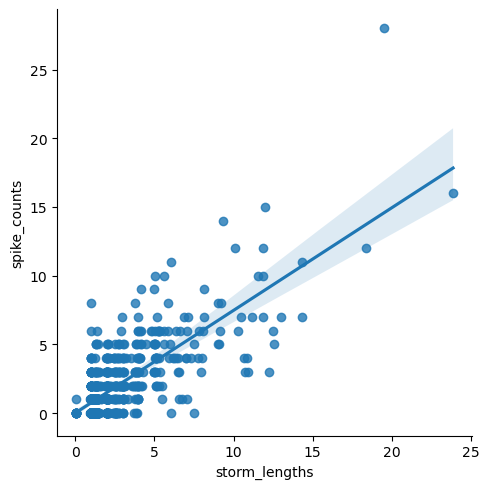

In [245]:
#scatterplot using seaborn

data = pd.DataFrame({'storm_lengths': storm_lengths, 'spike_counts': spike_counts})
sns.lmplot(x='storm_lengths', y='spike_counts', data=data)
plt.show()

In [246]:
X = np.array(storm_lengths).reshape(-1, 1)
Y = np.array(spike_counts).reshape(-1,1)

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=42)

#model is linear regression
regr = LinearRegression()

#train the model & print regression score of test
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.5088659193702143


In [247]:
print('number of spikes for each extra storm length, or b= ', regr.coef_)
print('number of spikes for 0 storm length, or a=', regr.intercept_)

number of spikes for each extra storm length, or b=  [[0.7512817]]
number of spikes for 0 storm length, or a= [-0.05405038]


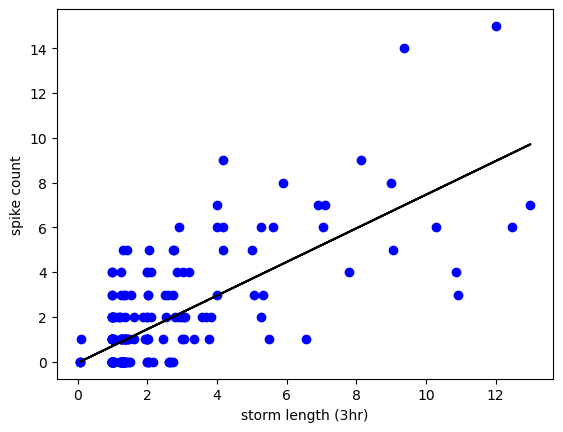

In [248]:
#graphing linear regression with test values

y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')
plt.xlabel('storm length (3hr)')
plt.ylabel('spike count')
plt.show()

In [249]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 1.2401518111437793
MSE: 2.941584650846098
RMSE: 1.715104851268895


In [250]:
#okay we see a linear relationship between length of storm and number of spikes. but that is to be expected.
# in general, the longer the storm the more spikes will occur.
# let's compare the parameters of the linear model to the overall number of spikes in a length of time
# I assume the number of spikes vs length of time relationship is linear

norm_num_spikes = np.linspace(start=df['3hr spike: sum'].mean(), stop = df['24hr spike: sum'].mean(), num=1000).reshape(-1, 1)
norm_storm_length = np.linspace(start=1, stop=8, num=1000).reshape(-1, 1)

#model is linear regression

base = LinearRegression()

#train the model
base.fit(norm_num_spikes, norm_storm_length)
#see coefficients
print('base case: number of spikes for each extra storm length, or bprime= ', base.coef_)
print('base case: number of spikes for 0 storm length, or aprime =', base.intercept_)


baseXtest = np.linspace(start=0.0, stop=12.0,num=100).reshape(-1, 1)
baseYpred = base.predict(baseXtest)

base case: number of spikes for each extra storm length, or bprime=  [[1.32362682]]
base case: number of spikes for 0 storm length, or aprime = [-0.00015556]


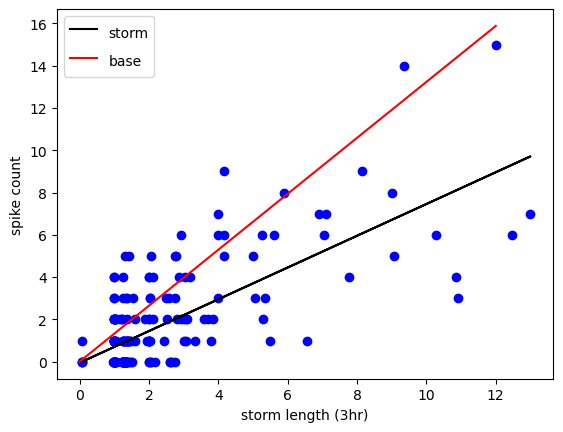

In [251]:
#graphing linear regression with test values overlaid by base case
fig, ax = plt.subplots()

plt.scatter(X_test, y_test, color ='b')
line1, = ax.plot(X_test, y_pred, color ='k', label='storm')
line2, = ax.plot(baseXtest, baseYpred, color = 'r', label='base')
ax.legend(handles=[line1, line2], handlelength=2, handleheight=2)
plt.xlabel('storm length (3hr)')
plt.ylabel('spike count')
plt.show()

# Results and Discussion

Kp values are induced by space and atmosphere conditions, and are unlikely to be associated with energy prices. Thus, I assume they -- and by extension, the price spikes and length of storms -- are independent variables.




Starting off with some descriptive statistics.

Remember we defined a spike as a price normalized by the past 3 hours whose p-value is less than 0.001.

Spikes occur among all 5 minute intervals about 2% of the time.
Spikes occur among all 3hr intervals about 42.67% of the time.
Spikes occur among all 24hr intervals about 99.46% of the time.

The average number of spikes in a 3hr interval is 0.7556.
The average number of spikes in a 24hr interval is 6.0441.

So in general, we see that the longer the time interval, the more spikes occur. The occurrence of a spike is random variable (for the purposes of this analysis). I assume that its relationship with the time interval is linear.

We have to examine the relationship of spikes against length of geomagnetic storms against this base condition and see of the strength of the relationship of the former is stronger than that of the latter.


Let's see some basic descriptive statistics about our X variable, length of storms, and Y variable, number of spikes during that storm. Remember a storm is defined as a consecutive period of 3hr intervals where the Kp value exceeds 5.

We have 776 storms or observations.

About 62.24% of storms have at least one spike; and on average storms have 1.85 spikes with a standard deviation of 2.49 spikes. This seems a lot, but consider that the average length of the storm is 2.48 (3hr intervals) with a standard deviation of 2.49 (3hr intervals). If we divide the mean spikes per storm by the mean length of storm we get an average of about 0.746 spikes per 3hr storm interval, which is actually slightly lower than the overall average number of spikes in a 3hr interval, 0.7556.

Let's move onto the linear regressions.

A scatterplot of X and Y confirms our suspicion that a linear model would be best.

SKlearn'slinear regression gives us the following coefficient values for a and b respectively: -0.05405038 and 0.7512817. 

So on average an extra 3hr duration for a storm is associated with an extra 0.7512817 spikes during that storm. Cool. That makes sense and is what we expected.  The  errors are decent as well:

MAE: 1.2401518111437793

MSE: 2.941584650846098

RMSE: 1.715104851268895

But the real question is how well does this compare to our base scenario. 

Using the overall average numbers of spikes in a 3hr interval and 24hr interval respectively we create a synthetic linear model that predicts the number of spikes for a duration of time from the dataset as a whole. The coefficients a' and b' are -0.00015556 and 1.32362682, respectively. As the last plot nicely illustrates, this linear relationship is even stronger than that of the storm events.


# Conclusion

In this project, a storm is defined as any consecutive period of 3hr intervals with Kp values above or equal to 5.0 for each period of time. For each storm the length of tthe storm (number of 3hr intervals) and how many spikes are observed for each storm are calculated. The hypothesis was that there is a positive linear relationship between the length of the storm and the number of spikes for storms of Kp >=5; and that the existence of such a storm has predictive ability for the occurence of a spike. At face value, the longer the storm the more likely a spike is to occur (and a greater number of spikes). However, for the alternate to a storm -- no storm -- the longer the time interval the more likely a spike is to occur (and a greater number of spikes). It turns out that the relationship of the latter is stronger than that of the former, significantly discounting the hypothesis that the length of a geogmatic storm (as we've defined it) uniquely predicts the occurence of price spikes. Our hypothesis predicted the exact opposite! Thus, I reject the hypothesis. That does not prove there is no casual relationship between geomagnetic activity and price spikes, however. Next steps could be retrying the analysis with a higher Kp threshhold and/or more strict p-value threshhold and using a more complex model, such as DecisionTreeClassifier or DecisionTreeRegressor to predict if time-lagging Kp values can predict price spikes.